# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
print("tf.__version__", tf.__version__)
if tf.__version__ < '1.4.0':
  print("less than 1.4.0")
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


tf.__version__ 1.4.0


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline
print("sys.path: ", sys.path)
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

sys.path:  ['', 'C:\\Users\\Administrator\\Documents\\models\\research\\slim', 'C:\\Users\\Administrator\\Documents\\models\\research', 'C:\\Users\\Administrator\\Documents\\models\\research\\object_detection', 'C:\\Users\\Administrator\\Anaconda3\\envs\\tensorflow-gpu\\python35.zip', 'C:\\Users\\Administrator\\Anaconda3\\envs\\tensorflow-gpu\\DLLs', 'C:\\Users\\Administrator\\Anaconda3\\envs\\tensorflow-gpu\\lib', 'C:\\Users\\Administrator\\Anaconda3\\envs\\tensorflow-gpu', 'C:\\Users\\Administrator\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages', 'C:\\Users\\Administrator\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\Sphinx-1.6.3-py3.5.egg', 'C:\\Users\\Administrator\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Administrator\\.ipython']


## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
print("MODEL_FILE: ", MODEL_FILE)
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90
print("current working directory: ", os.getcwd())

MODEL_FILE:  ssd_mobilenet_v1_coco_2017_11_17.tar.gz
current working directory:  C:\Users\Administrator\Documents\models\research\object_detection


## Download Model

In [5]:
opener = urllib.request.FancyURLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
print("url retrieve success")
print("MODEL_FILE: ", MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  print("file.name", file.name)
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

C:\Users\Administrator\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: FancyURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  """Entry point for launching an IPython kernel.


url retrieve success
MODEL_FILE:  ssd_mobilenet_v1_coco_2017_11_17.tar.gz
file.name ssd_mobilenet_v1_coco_2017_11_17
file.name ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.index
file.name ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.meta
file.name ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb
file.name ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.data-00000-of-00001
file.name ssd_mobilenet_v1_coco_2017_11_17/saved_model
file.name ssd_mobilenet_v1_coco_2017_11_17/saved_model/saved_model.pb
file.name ssd_mobilenet_v1_coco_2017_11_17/saved_model/variables
file.name ssd_mobilenet_v1_coco_2017_11_17/checkpoint


## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph1 = tf.Graph()
with detection_graph1.as_default():
    c = tf.constant("Node in detection_graph")
g = tf.get_default_graph()
print(g)
print(g.get_operations())

[]


In [8]:
detection_graph = tf.Graph()
print(detection_graph)
with detection_graph.as_default():
  print(tf.get_default_graph())
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

#print("od_graph_def: ", od_graph_def)
print(tf.get_default_graph())


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [9]:
print(PATH_TO_LABELS)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(categories)

data\mscoco_label_map.pbtxt
[{'id': 1, 'name': 'person'}, {'id': 2, 'name': 'bicycle'}, {'id': 3, 'name': 'car'}, {'id': 4, 'name': 'motorcycle'}, {'id': 5, 'name': 'airplane'}, {'id': 6, 'name': 'bus'}, {'id': 7, 'name': 'train'}, {'id': 8, 'name': 'truck'}, {'id': 9, 'name': 'boat'}, {'id': 10, 'name': 'traffic light'}, {'id': 11, 'name': 'fire hydrant'}, {'id': 13, 'name': 'stop sign'}, {'id': 14, 'name': 'parking meter'}, {'id': 15, 'name': 'bench'}, {'id': 16, 'name': 'bird'}, {'id': 17, 'name': 'cat'}, {'id': 18, 'name': 'dog'}, {'id': 19, 'name': 'horse'}, {'id': 20, 'name': 'sheep'}, {'id': 21, 'name': 'cow'}, {'id': 22, 'name': 'elephant'}, {'id': 23, 'name': 'bear'}, {'id': 24, 'name': 'zebra'}, {'id': 25, 'name': 'giraffe'}, {'id': 27, 'name': 'backpack'}, {'id': 28, 'name': 'umbrella'}, {'id': 31, 'name': 'handbag'}, {'id': 32, 'name': 'tie'}, {'id': 33, 'name': 'suitcase'}, {'id': 34, 'name': 'frisbee'}, {'id': 35, 'name': 'skis'}, {'id': 36, 'name': 'snowboard'}, {'id': 3

## Helper code

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [12]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
print(TEST_IMAGE_PATHS)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['test_images\\image1.jpg', 'test_images\\image2.jpg']


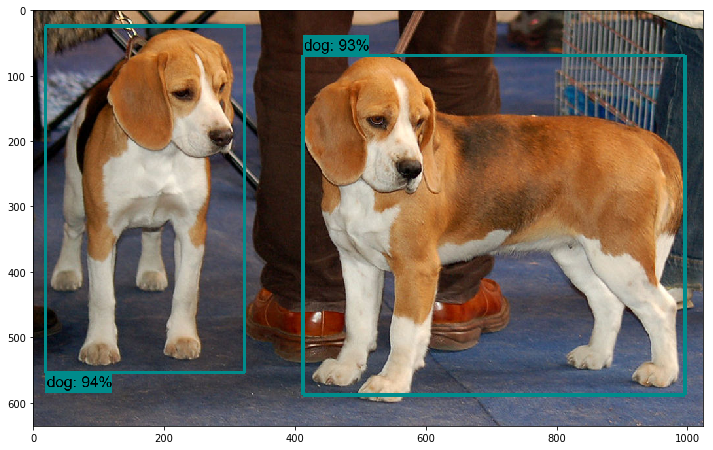

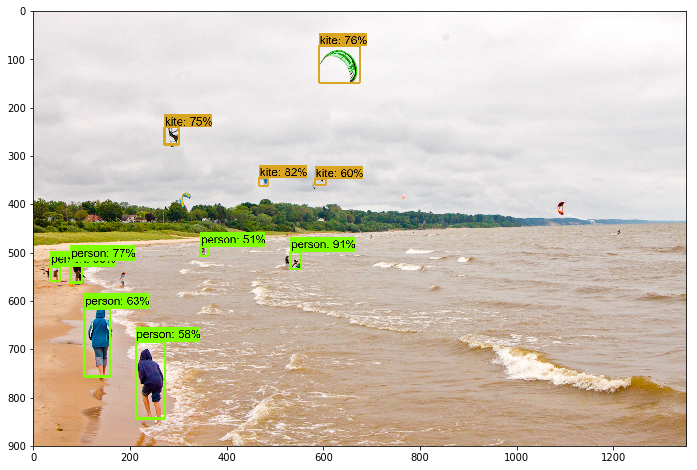

In [13]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=5)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)